In [94]:
# adapted from Xabier Garcia Andrade's code at https://github.com/XabierGA/DNN_Julia

using Random
using LinearAlgebra
using Statistics
using Plots
using DelimitedFiles
pyplot()

#####################
# Activation Functions
#####################
function sigmoid(X)
    sigma = 1 ./(1 .+ exp.(.-X))
    return sigma, X
end

function relu(X)
    rel = max.(0,X)
    return rel, X
end

function tanh_nn(X)
    result = (exp.(X).-exp.(.-X))./(exp.(X).+exp.(.-X))
    return result, X
end

function leaky_relu(X)
    rel = max.(0.01.*X,X)
    return rel, X
end

#####################
# Params
#####################
function init_param(layer_dimensions, activation_functions)

    param = Dict()

    for l=1:length(layer_dimensions)-1

        param[string("W_" , string(l))] = 0.01f0*randn(layer_dimensions[l+1] , layer_dimensions[l])
        param[string("b_" , string(l))] = zeros(layer_dimensions[l+1] , 1)
		param[string("g_" , string(l))] = activation_functions[l]
    end

    return param

end

function update_param(parameters, grads, learning_rate, lambda, m)

	L = Int(length(parameters)/3)

	for l = 0:(L-1)

		parameters[string("W_", string(l+1))] *= (1 - learning_rate * lambda / m)
		parameters[string("W_", string(l+1))] -= learning_rate.*grads[string("dW_", string(l+1))]
		parameters[string("b_", string(l+1))] -= learning_rate.*grads[string("db_", string(l+1))]

	end

	return parameters

end

#####################
# Forward Propagation
#####################
function forward_linear(A,w,b)

    Z = w*A .+ b
    cache = (A, w, b)

    return Z, cache
end

function calculate_activation_forward(A_pre, W, b, function_type)

    if (function_type == "sigmoid")

        Z, linear_step_cache = forward_linear(A_pre, W, b)
        A, activation_step_cache = sigmoid(Z)

    elseif (function_type == "relu")

        Z, linear_step_cache = forward_linear(A_pre, W, b)
        A, activation_step_cache = relu(Z)

    elseif (function_type == "tanh_nn")

        Z, linear_step_cache = forward_linear(A_pre, W, b)
        A, activation_step_cache = tanh_nn(Z)

    elseif (function_type == "leaky_relu")

        Z, linear_step_cache = forward_linear(A_pre, W, b)
        A, activation_step_cache = leaky_relu(Z)

    end

    cache = (linear_step_cache, activation_step_cache, function_type) # ((A_pre, W, b), (Z), "function")
    return A, cache

end


function model_forward_step(X, params)

    all_caches = []
    A = X
    L = length(params)/3

    for l = 1:L-1
        A_pre = A
        A, cache = calculate_activation_forward(A_pre,  params[string("W_", string(Int(l)))],
                                                        params[string("b_", string(Int(l)))],
                                                        params[string("g_", string(Int(l)))])
        push!(all_caches, cache)
    end
	A_l, cache = calculate_activation_forward(A, params[string("W_", string(Int(L)))],
												 params[string("b_", string(Int(L)))],
												 params[string("g_", string(Int(L)))])
 	push!(all_caches, cache)

    return A_l, all_caches

end

function cost_function(AL, Y)

    cost = -mean(Y.*log.(AL) + (1 .- Y).*log.(1 .- AL))

    return cost

end

function apply_regularization(cost, params, lambda, m)
	L = length(params)/3
	for l = 1:L
		W = params[string("W_", string(Int(l)))]
		for i = 1:size(W,1)
			for j = 1:size(W,2)
				cost += lambda / 2 / m * W[i,j] * W[i,j]
			end
		end
	end
	return cost
end

function check_accuracy(A_L , Y)
    A_L = reshape(A_L , size(Y))
    return sum((A_L.>0.5) .== Y)/length(Y)
end

#####################
# Back Propagation
#####################
function backward_linear_step(dZ, cache)

    A_prev, W, b = cache

    m = size(A_prev)[2]

    dW = dZ * (A_prev')/m
    db = sum(dZ, dims = 2)/m
    dA_prev = (W')* dZ
    return dW, db, dA_prev

end

function backward_relu(dA, cache_activation)
    return dA.*(cache_activation.>0)
end

function backward_leaky_relu(dA, cache_activation)
    temp = convert.(Int, cache_activation.>0) .+ convert.(Int, cache_activation.<=0) .* 0.01
    return dA.*(temp)
end

function backward_sigmoid(dA, cache_activation)
    return dA.*(sigmoid(cache_activation)[1].*(1 .- sigmoid(cache_activation)[1]))
end

function backward_tanh_nn(dA, cache_activation)
    return dA.*(1 .-tanh_nn(cache_activation)[1].*tanh_nn(cache_activation)[1])
end

function backward_activation_step(dA, cache)

    linear_cache , cache_activation, activation = cache
    if (activation == "relu")

        dZ = backward_relu(dA, cache_activation)
        dW, db, dA_prev = backward_linear_step(dZ, linear_cache)

    elseif (activation == "sigmoid")

        dZ = backward_sigmoid(dA, cache_activation)
        dW, db, dA_prev = backward_linear_step(dZ, linear_cache)

    elseif (activation == "leaky_relu")

        dZ = backward_leaky_relu(dA, cache_activation)
        dW, db, dA_prev = backward_linear_step(dZ, linear_cache)

    elseif (activation == "tanh_nn")

        dZ = backward_tanh_nn(dA, cache_activation)
        dW, db, dA_prev = backward_linear_step(dZ, linear_cache)

    end

    return dW, db, dA_prev

end

function (model_backwards_step(A_l, Y, caches))

    grads = Dict()

    L = length(caches)

    m = size(A_l)[2]

    Y = reshape(Y, size(A_l))
    dA_l = (-(Y./A_l) .+ ((1 .- Y)./(1 .- A_l)))
    current_cache = caches[L]
    grads[string("dW_", string(L))], grads[string("db_", string(L))], grads[string("dA_", string(L-1))] = backward_activation_step(dA_l, current_cache)

    for l = reverse(0:L-2)
        current_cache = caches[l+1]
        grads[string("dW_", string(l+1))], grads[string("db_", string(l+1))], grads[string("dA_", string(l))] = backward_activation_step(grads[string("dA_", string(l+1))], current_cache)
    end

    return grads
end

#####################
# Train NN
#####################
function train_nn(layers_dimensions, activation_functions, X , Y , learning_rate , n_iter, lambda)

    params = init_param(layers_dimensions, activation_functions)
    costs = []
    iters = []
    accuracy = []
	m = size(X,2)
    for i=1:n_iter
        A_l , caches  = model_forward_step(X , params)
        cost = cost_function(A_l , Y)
		cost = apply_regularization(cost, params, lambda, m)
        acc = check_accuracy(A_l , Y)
        grads  = model_backwards_step(A_l , Y , caches)
        params = update_param(params , grads , learning_rate, lambda, m)
        println("Iteration ->" , i)
        println("Cost ->" , cost)
        println("Accuracy -> " , acc)
        push!(iters , i)
        push!(costs , cost)
        push!(accuracy , acc)

    end
    plt = plot(iters , costs ,title =  "Cost Function vs Number of Iterations" , lab ="J")
    xaxis!("N_Iterations")
    yaxis!("J")
    plt_2 = plot(iters , accuracy ,title =  "Accuracy vs Number of Iterations" , lab ="Acc" , color = :green)
    xaxis!("N_Iterations")
    yaxis!("Accuracy")
    plot(plt , plt_2 , layout = (2,1))
    savefig("cost_plot_rand.pdf")
    return params , costs

end

train_nn (generic function with 1 method)

Iteration ->1
Cost ->0.6931602663848241
Accuracy -> 0.51
Iteration ->2
Cost ->0.6930492333862748
Accuracy -> 0.52
Iteration ->3
Cost ->0.6929461564232736
Accuracy -> 0.52
Iteration ->4
Cost ->0.6928493423698049
Accuracy -> 0.52
Iteration ->5
Cost ->0.6927562899890911
Accuracy -> 0.52
Iteration ->6
Cost ->0.6926655384144295
Accuracy -> 0.52
Iteration ->7
Cost ->0.6925751522840922
Accuracy -> 0.52
Iteration ->8
Cost ->0.692482550783098
Accuracy -> 0.52
Iteration ->9
Cost ->0.6923857977919335
Accuracy -> 0.52
Iteration ->10
Cost ->0.6922833763206089
Accuracy -> 0.52
Iteration ->11
Cost ->0.6921724574957595
Accuracy -> 0.52
Iteration ->12
Cost ->0.6920512700361319
Accuracy -> 0.52
Iteration ->13
Cost ->0.6919172129574698
Accuracy -> 0.52
Iteration ->14
Cost ->0.6917664213225262
Accuracy -> 0.52
Iteration ->15
Cost ->0.691594986584407
Accuracy -> 0.52
Iteration ->16
Cost ->0.6913987603830865
Accuracy -> 0.52
Iteration ->17
Cost ->0.6911731074893752
Accuracy -> 0.52
Iteration ->18
Cost ->0.6

Accuracy -> 0.9
Iteration ->177
Cost ->0.37429093098872396
Accuracy -> 0.9
Iteration ->178
Cost ->0.3731658775151221
Accuracy -> 0.9
Iteration ->179
Cost ->0.37214705374985735
Accuracy -> 0.9
Iteration ->180
Cost ->0.37092800486450717
Accuracy -> 0.9
Iteration ->181
Cost ->0.36976581709604706
Accuracy -> 0.91
Iteration ->182
Cost ->0.3686673654327838
Accuracy -> 0.91
Iteration ->183
Cost ->0.36755237176644073
Accuracy -> 0.91
Iteration ->184
Cost ->0.3664265152229664
Accuracy -> 0.91
Iteration ->185
Cost ->0.36532764552670344
Accuracy -> 0.91
Iteration ->186
Cost ->0.36430092026587235
Accuracy -> 0.91
Iteration ->187
Cost ->0.36330360840882986
Accuracy -> 0.94
Iteration ->188
Cost ->0.36216798588066146
Accuracy -> 0.93
Iteration ->189
Cost ->0.36112295636781305
Accuracy -> 0.93
Iteration ->190
Cost ->0.3600370487382696
Accuracy -> 0.93
Iteration ->191
Cost ->0.3590046479352922
Accuracy -> 0.93
Iteration ->192
Cost ->0.358003089895808
Accuracy -> 0.93
Iteration ->193
Cost ->0.3569680907

Iteration ->349
Cost ->0.26037913312530503
Accuracy -> 0.97
Iteration ->350
Cost ->0.26000222066168466
Accuracy -> 0.97
Iteration ->351
Cost ->0.2596600010257704
Accuracy -> 0.97
Iteration ->352
Cost ->0.2592800799367801
Accuracy -> 0.97
Iteration ->353
Cost ->0.25890477497176106
Accuracy -> 0.97
Iteration ->354
Cost ->0.2585339048187528
Accuracy -> 0.97
Iteration ->355
Cost ->0.25816315631992814
Accuracy -> 0.97
Iteration ->356
Cost ->0.25779724371528334
Accuracy -> 0.97
Iteration ->357
Cost ->0.25743077322805513
Accuracy -> 0.97
Iteration ->358
Cost ->0.25706944945626536
Accuracy -> 0.97
Iteration ->359
Cost ->0.2567071734083761
Accuracy -> 0.97
Iteration ->360
Cost ->0.25636160372483274
Accuracy -> 0.97
Iteration ->361
Cost ->0.256249947406648
Accuracy -> 0.97
Iteration ->362
Cost ->0.25570021831570144
Accuracy -> 0.97
Iteration ->363
Cost ->0.25533323384799267
Accuracy -> 0.97
Iteration ->364
Cost ->0.25497969926268776
Accuracy -> 0.97
Iteration ->365
Cost ->0.25462941338976625
Acc

Iteration ->507
Cost ->0.22163786930134063
Accuracy -> 0.98
Iteration ->508
Cost ->0.22151610881889136
Accuracy -> 0.98
Iteration ->509
Cost ->0.22122832710945387
Accuracy -> 0.98
Iteration ->510
Cost ->0.22129655494880954
Accuracy -> 0.98
Iteration ->511
Cost ->0.22083534207135938
Accuracy -> 0.98
Iteration ->512
Cost ->0.22133489640096415
Accuracy -> 0.98
Iteration ->513
Cost ->0.22060710283329613
Accuracy -> 0.98
Iteration ->514
Cost ->0.2204472369262522
Accuracy -> 0.98
Iteration ->515
Cost ->0.2208330794844649
Accuracy -> 0.98
Iteration ->516
Cost ->0.22013442807046935
Accuracy -> 0.98
Iteration ->517
Cost ->0.22001649208862123
Accuracy -> 0.98
Iteration ->518
Cost ->0.21994871461432966
Accuracy -> 0.98
Iteration ->519
Cost ->0.21960771482447158
Accuracy -> 0.98
Iteration ->520
Cost ->0.21971853249837853
Accuracy -> 0.98
Iteration ->521
Cost ->0.21968332539735677
Accuracy -> 0.98
Iteration ->522
Cost ->0.21924093319891383
Accuracy -> 0.98
Iteration ->523
Cost ->0.21911008960940406

Accuracy -> 0.98
Iteration ->679
Cost ->0.20001367802563097
Accuracy -> 0.98
Iteration ->680
Cost ->0.200069904174702
Accuracy -> 0.98
Iteration ->681
Cost ->0.19986872110872728
Accuracy -> 0.98
Iteration ->682
Cost ->0.19972053833583103
Accuracy -> 0.98
Iteration ->683
Cost ->0.19985463789444202
Accuracy -> 0.98
Iteration ->684
Cost ->0.19946581816819628
Accuracy -> 0.98
Iteration ->685
Cost ->0.19950146772303307
Accuracy -> 0.98
Iteration ->686
Cost ->0.19951846667441808
Accuracy -> 0.98
Iteration ->687
Cost ->0.19920777961713282
Accuracy -> 0.98
Iteration ->688
Cost ->0.19925775067086834
Accuracy -> 0.98
Iteration ->689
Cost ->0.19910225697723918
Accuracy -> 0.98
Iteration ->690
Cost ->0.19905658928594652
Accuracy -> 0.98
Iteration ->691
Cost ->0.19883788405920044
Accuracy -> 0.98
Iteration ->692
Cost ->0.1989264210664718
Accuracy -> 0.98
Iteration ->693
Cost ->0.19872287282822343
Accuracy -> 0.98
Iteration ->694
Cost ->0.19856397191911856
Accuracy -> 0.98
Iteration ->695
Cost ->0.1

Cost ->0.18579504164835814
Accuracy -> 0.98
Iteration ->851
Cost ->0.185727042307292
Accuracy -> 0.98
Iteration ->852
Cost ->0.18582080550053662
Accuracy -> 0.98
Iteration ->853
Cost ->0.18569480698495405
Accuracy -> 0.98
Iteration ->854
Cost ->0.18566950634130155
Accuracy -> 0.98
Iteration ->855
Cost ->0.18544334866409132
Accuracy -> 0.98
Iteration ->856
Cost ->0.1854366518123861
Accuracy -> 0.98
Iteration ->857
Cost ->0.1855701230264016
Accuracy -> 0.98
Iteration ->858
Cost ->0.18528090468486566
Accuracy -> 0.98
Iteration ->859
Cost ->0.1853420831665099
Accuracy -> 0.98
Iteration ->860
Cost ->0.18517161103806629
Accuracy -> 0.98
Iteration ->861
Cost ->0.18516258909403763
Accuracy -> 0.98
Iteration ->862
Cost ->0.18517315224749764
Accuracy -> 0.98
Iteration ->863
Cost ->0.18492129077543787
Accuracy -> 0.98
Iteration ->864
Cost ->0.1850820097181034
Accuracy -> 0.98
Iteration ->865
Cost ->0.1848892142001952
Accuracy -> 0.98
Iteration ->866
Cost ->0.1847620425069616
Accuracy -> 0.98
Iter

Accuracy -> 0.98
Iteration ->1107
Cost ->0.1726415100692658
Accuracy -> 0.98
Iteration ->1108
Cost ->0.17276311415847506
Accuracy -> 0.98
Iteration ->1109
Cost ->0.17264282640985143
Accuracy -> 0.98
Iteration ->1110
Cost ->0.1726242046384645
Accuracy -> 0.98
Iteration ->1111
Cost ->0.17252603538983521
Accuracy -> 0.98
Iteration ->1112
Cost ->0.172619024484513
Accuracy -> 0.98
Iteration ->1113
Cost ->0.17247715039894806
Accuracy -> 0.98
Iteration ->1114
Cost ->0.17243201031838026
Accuracy -> 0.98
Iteration ->1115
Cost ->0.1723692924549609
Accuracy -> 0.98
Iteration ->1116
Cost ->0.17247239153174748
Accuracy -> 0.98
Iteration ->1117
Cost ->0.17231809459329803
Accuracy -> 0.98
Iteration ->1118
Cost ->0.17226413138190816
Accuracy -> 0.98
Iteration ->1119
Cost ->0.17215115599065442
Accuracy -> 0.98
Iteration ->1120
Cost ->0.172346454351162
Accuracy -> 0.98
Iteration ->1121
Cost ->0.17217106442431673
Accuracy -> 0.98
Iteration ->1122
Cost ->0.17212070421167946
Accuracy -> 0.98
Iteration ->11

Accuracy -> 0.98
Iteration ->1276
Cost ->0.16661447334811152
Accuracy -> 0.99
Iteration ->1277
Cost ->0.16651142264326263
Accuracy -> 0.98
Iteration ->1278
Cost ->0.16653180059123338
Accuracy -> 0.99
Iteration ->1279
Cost ->0.166377146057637
Accuracy -> 0.98
Iteration ->1280
Cost ->0.16657865151911902
Accuracy -> 0.99
Iteration ->1281
Cost ->0.16645631645109651
Accuracy -> 0.98
Iteration ->1282
Cost ->0.16638033591348403
Accuracy -> 0.99
Iteration ->1283
Cost ->0.1662780960761841
Accuracy -> 0.98
Iteration ->1284
Cost ->0.16637489068744604
Accuracy -> 0.99
Iteration ->1285
Cost ->0.1663913124471072
Accuracy -> 0.98
Iteration ->1286
Cost ->0.16626081368122517
Accuracy -> 0.99
Iteration ->1287
Cost ->0.16616588691072282
Accuracy -> 0.98
Iteration ->1288
Cost ->0.16621261980644625
Accuracy -> 0.99
Iteration ->1289
Cost ->0.16612828206718677
Accuracy -> 0.98
Iteration ->1290
Cost ->0.16621763491879082
Accuracy -> 0.99
Iteration ->1291
Cost ->0.1661122061401772
Accuracy -> 0.98
Iteration ->

Accuracy -> 0.98
Iteration ->1445
Cost ->0.16160554115491357
Accuracy -> 0.99
Iteration ->1446
Cost ->0.16152289935903133
Accuracy -> 0.99
Iteration ->1447
Cost ->0.16155777113648806
Accuracy -> 0.99
Iteration ->1448
Cost ->0.16159988905412156
Accuracy -> 0.98
Iteration ->1449
Cost ->0.16151126907985108
Accuracy -> 0.99
Iteration ->1450
Cost ->0.16144551922997913
Accuracy -> 0.99
Iteration ->1451
Cost ->0.1614485987868555
Accuracy -> 0.99
Iteration ->1452
Cost ->0.16133552569644075
Accuracy -> 0.99
Iteration ->1453
Cost ->0.16145706261629117
Accuracy -> 0.99
Iteration ->1454
Cost ->0.16145500546248476
Accuracy -> 0.98
Iteration ->1455
Cost ->0.16133056464829898
Accuracy -> 0.99
Iteration ->1456
Cost ->0.16126654340601182
Accuracy -> 0.99
Iteration ->1457
Cost ->0.16128605264726395
Accuracy -> 0.99
Iteration ->1458
Cost ->0.16120531882154138
Accuracy -> 0.99
Iteration ->1459
Cost ->0.16133149592224527
Accuracy -> 0.99
Iteration ->1460
Cost ->0.1612453295103277
Accuracy -> 0.99
Iteration

Cost ->0.15642840071009068
Accuracy -> 0.99
Iteration ->1664
Cost ->0.1564496887773347
Accuracy -> 0.99
Iteration ->1665
Cost ->0.15632051709145534
Accuracy -> 0.99
Iteration ->1666
Cost ->0.15630021679624004
Accuracy -> 0.99
Iteration ->1667
Cost ->0.15628402264153446
Accuracy -> 0.99
Iteration ->1668
Cost ->0.15622501711708298
Accuracy -> 0.99
Iteration ->1669
Cost ->0.15630928623800644
Accuracy -> 0.99
Iteration ->1670
Cost ->0.15629960012897992
Accuracy -> 0.99
Iteration ->1671
Cost ->0.15617213124492074
Accuracy -> 0.99
Iteration ->1672
Cost ->0.15618401299181034
Accuracy -> 0.99
Iteration ->1673
Cost ->0.15614457381617877
Accuracy -> 0.99
Iteration ->1674
Cost ->0.1561176744266813
Accuracy -> 0.99
Iteration ->1675
Cost ->0.15616648969227398
Accuracy -> 0.99
Iteration ->1676
Cost ->0.1560592845441601
Accuracy -> 0.99
Iteration ->1677
Cost ->0.15611514180247563
Accuracy -> 0.99
Iteration ->1678
Cost ->0.15610514847647652
Accuracy -> 0.99
Iteration ->1679
Cost ->0.15599220806655012


Iteration ->1832
Cost ->0.1529983224675346
Accuracy -> 0.99
Iteration ->1833
Cost ->0.15296225368151364
Accuracy -> 0.99
Iteration ->1834
Cost ->0.1529446012194227
Accuracy -> 0.99
Iteration ->1835
Cost ->0.15291230660468474
Accuracy -> 0.99
Iteration ->1836
Cost ->0.15299389462531984
Accuracy -> 0.99
Iteration ->1837
Cost ->0.15280817349378914
Accuracy -> 0.99
Iteration ->1838
Cost ->0.1528994550921177
Accuracy -> 0.99
Iteration ->1839
Cost ->0.15283626355090393
Accuracy -> 0.99
Iteration ->1840
Cost ->0.15285515682299952
Accuracy -> 0.99
Iteration ->1841
Cost ->0.15278234558186546
Accuracy -> 0.99
Iteration ->1842
Cost ->0.15279043322001634
Accuracy -> 0.99
Iteration ->1843
Cost ->0.1527468405238469
Accuracy -> 0.99
Iteration ->1844
Cost ->0.15284477613257216
Accuracy -> 0.99
Iteration ->1845
Cost ->0.1526708090306028
Accuracy -> 0.99
Iteration ->1846
Cost ->0.15279328239051737
Accuracy -> 0.99
Iteration ->1847
Cost ->0.15266537735271696
Accuracy -> 0.99
Iteration ->1848
Cost ->0.152

Accuracy -> 0.99
Iteration ->2001
Cost ->0.1499983243998159
Accuracy -> 0.99
Iteration ->2002
Cost ->0.15001546074952543
Accuracy -> 0.99
Iteration ->2003
Cost ->0.14998191780858125
Accuracy -> 0.99
Iteration ->2004
Cost ->0.15004726039998162
Accuracy -> 0.99
Iteration ->2005
Cost ->0.14990070182006746
Accuracy -> 0.99
Iteration ->2006
Cost ->0.14996079530282588
Accuracy -> 0.99
Iteration ->2007
Cost ->0.14992161739854093
Accuracy -> 0.99
Iteration ->2008
Cost ->0.1499121538473493
Accuracy -> 0.99
Iteration ->2009
Cost ->0.1498738823788596
Accuracy -> 0.99
Iteration ->2010
Cost ->0.14985927423322323
Accuracy -> 0.99
Iteration ->2011
Cost ->0.14983701594689447
Accuracy -> 0.99
Iteration ->2012
Cost ->0.14991708430069883
Accuracy -> 0.99
Iteration ->2013
Cost ->0.14974435974417954
Accuracy -> 0.99
Iteration ->2014
Cost ->0.1498465113879691
Accuracy -> 0.99
Iteration ->2015
Cost ->0.14976416982612006
Accuracy -> 0.99
Iteration ->2016
Cost ->0.14979542275096136
Accuracy -> 0.99
Iteration -

Cost ->0.14739138527411333
Accuracy -> 0.99
Iteration ->2172
Cost ->0.14733994464139433
Accuracy -> 0.99
Iteration ->2173
Cost ->0.1473917642932591
Accuracy -> 0.99
Iteration ->2174
Cost ->0.14736514799951728
Accuracy -> 0.99
Iteration ->2175
Cost ->0.14752933694153905
Accuracy -> 0.99
Iteration ->2176
Cost ->0.147288896778798
Accuracy -> 0.99
Iteration ->2177
Cost ->0.14736820825259045
Accuracy -> 0.99
Iteration ->2178
Cost ->0.14727456518962878
Accuracy -> 0.99
Iteration ->2179
Cost ->0.1472977494654322
Accuracy -> 0.99
Iteration ->2180
Cost ->0.1472495228402615
Accuracy -> 0.99
Iteration ->2181
Cost ->0.14724886973904364
Accuracy -> 0.99
Iteration ->2182
Cost ->0.14721880712711347
Accuracy -> 0.99
Iteration ->2183
Cost ->0.14721403315284723
Accuracy -> 0.99
Iteration ->2184
Cost ->0.14722274421610002
Accuracy -> 0.99
Iteration ->2185
Cost ->0.14727952500941666
Accuracy -> 0.99
Iteration ->2186
Cost ->0.14710371792991653
Accuracy -> 0.99
Iteration ->2187
Cost ->0.1472092376623953
Acc

Cost ->0.1451049395700852
Accuracy -> 0.99
Iteration ->2341
Cost ->0.14505310097689397
Accuracy -> 0.99
Iteration ->2342
Cost ->0.1451813488423123
Accuracy -> 0.99
Iteration ->2343
Cost ->0.14506119408108895
Accuracy -> 0.99
Iteration ->2344
Cost ->0.1450614350882777
Accuracy -> 0.99
Iteration ->2345
Cost ->0.14503253834355762
Accuracy -> 0.99
Iteration ->2346
Cost ->0.1450066794455029
Accuracy -> 0.99
Iteration ->2347
Cost ->0.14499903713947696
Accuracy -> 0.99
Iteration ->2348
Cost ->0.1450572755298267
Accuracy -> 0.99
Iteration ->2349
Cost ->0.14490708688536633
Accuracy -> 0.99
Iteration ->2350
Cost ->0.14502284789680123
Accuracy -> 0.99
Iteration ->2351
Cost ->0.1448960038692593
Accuracy -> 0.99
Iteration ->2352
Cost ->0.14498587650987435
Accuracy -> 0.99
Iteration ->2353
Cost ->0.1449343263757512
Accuracy -> 0.99
Iteration ->2354
Cost ->0.144977287300576
Accuracy -> 0.99
Iteration ->2355
Cost ->0.1448962390131235
Accuracy -> 0.99
Iteration ->2356
Cost ->0.14490298882201547
Accurac

Iteration ->2509
Cost ->0.14303729373323007
Accuracy -> 0.99
Iteration ->2510
Cost ->0.14304803566348287
Accuracy -> 0.99
Iteration ->2511
Cost ->0.14300449719018538
Accuracy -> 0.99
Iteration ->2512
Cost ->0.1430812653516994
Accuracy -> 0.99
Iteration ->2513
Cost ->0.14292434241647642
Accuracy -> 0.99
Iteration ->2514
Cost ->0.14302749277794377
Accuracy -> 0.99
Iteration ->2515
Cost ->0.14301278726124914
Accuracy -> 0.99
Iteration ->2516
Cost ->0.14291320461047885
Accuracy -> 0.99
Iteration ->2517
Cost ->0.14308560523082975
Accuracy -> 0.99
Iteration ->2518
Cost ->0.14292401246067965
Accuracy -> 0.99
Iteration ->2519
Cost ->0.14296680679255014
Accuracy -> 0.99
Iteration ->2520
Cost ->0.14288943021405975
Accuracy -> 0.99
Iteration ->2521
Cost ->0.1429134338855985
Accuracy -> 0.99
Iteration ->2522
Cost ->0.1428501204780437
Accuracy -> 0.99
Iteration ->2523
Cost ->0.14287695181501905
Accuracy -> 0.99
Iteration ->2524
Cost ->0.1428081359908697
Accuracy -> 0.99
Iteration ->2525
Cost ->0.14

Cost ->0.1408670626101191
Accuracy -> 0.99
Iteration ->2712
Cost ->0.14080041172610974
Accuracy -> 0.99
Iteration ->2713
Cost ->0.14082769668179188
Accuracy -> 0.99
Iteration ->2714
Cost ->0.14077766329264227
Accuracy -> 0.99
Iteration ->2715
Cost ->0.1409345159514996
Accuracy -> 0.99
Iteration ->2716
Cost ->0.14080244982161105
Accuracy -> 0.99
Iteration ->2717
Cost ->0.14081866126150858
Accuracy -> 0.99
Iteration ->2718
Cost ->0.14075656687539065
Accuracy -> 0.99
Iteration ->2719
Cost ->0.1407686958408619
Accuracy -> 0.99
Iteration ->2720
Cost ->0.14070850168092014
Accuracy -> 0.99
Iteration ->2721
Cost ->0.1407535649282469
Accuracy -> 0.99
Iteration ->2722
Cost ->0.14076996342655126
Accuracy -> 0.99
Iteration ->2723
Cost ->0.1407852465117484
Accuracy -> 0.99
Iteration ->2724
Cost ->0.14071093052126984
Accuracy -> 0.99
Iteration ->2725
Cost ->0.14071492851621067
Accuracy -> 0.99
Iteration ->2726
Cost ->0.14066429737153407
Accuracy -> 0.99
Iteration ->2727
Cost ->0.14067627736700153
Ac

Accuracy -> 0.99
Iteration ->2881
Cost ->0.13914790618329878
Accuracy -> 0.99
Iteration ->2882
Cost ->0.1393407150731124
Accuracy -> 0.99
Iteration ->2883
Cost ->0.1391669246389761
Accuracy -> 0.99
Iteration ->2884
Cost ->0.1392238633025081
Accuracy -> 0.99
Iteration ->2885
Cost ->0.13911298306367184
Accuracy -> 0.99
Iteration ->2886
Cost ->0.13917351359222535
Accuracy -> 0.99
Iteration ->2887
Cost ->0.13908522604329232
Accuracy -> 0.99
Iteration ->2888
Cost ->0.1392875033797181
Accuracy -> 0.99
Iteration ->2889
Cost ->0.1391122271335218
Accuracy -> 0.99
Iteration ->2890
Cost ->0.1391706619143357
Accuracy -> 0.99
Iteration ->2891
Cost ->0.13905777832819768
Accuracy -> 0.99
Iteration ->2892
Cost ->0.13912021191974172
Accuracy -> 0.99
Iteration ->2893
Cost ->0.13902565226427466
Accuracy -> 0.99
Iteration ->2894
Cost ->0.13922029409169
Accuracy -> 0.99
Iteration ->2895
Cost ->0.1391659746478227
Accuracy -> 0.99
Iteration ->2896
Cost ->0.13904346147233757
Accuracy -> 0.99
Iteration ->2897


Accuracy -> 0.99
Iteration ->3088
Cost ->0.13747573473060587
Accuracy -> 0.99
Iteration ->3089
Cost ->0.13737117244100547
Accuracy -> 0.99
Iteration ->3090
Cost ->0.13740257884408363
Accuracy -> 0.99
Iteration ->3091
Cost ->0.13732498728073164
Accuracy -> 0.99
Iteration ->3092
Cost ->0.13752153710297235
Accuracy -> 0.99
Iteration ->3093
Cost ->0.13735824783866765
Accuracy -> 0.99
Iteration ->3094
Cost ->0.13740454652900655
Accuracy -> 0.99
Iteration ->3095
Cost ->0.13733381333229888
Accuracy -> 0.99
Iteration ->3096
Cost ->0.13736728731982562
Accuracy -> 0.99
Iteration ->3097
Cost ->0.13735621516220273
Accuracy -> 0.99
Iteration ->3098
Cost ->0.137466843925733
Accuracy -> 0.99
Iteration ->3099
Cost ->0.13730009581363883
Accuracy -> 0.99
Iteration ->3100
Cost ->0.13734018729073125
Accuracy -> 0.99
Iteration ->3101
Cost ->0.13723241576464718
Accuracy -> 0.99
Iteration ->3102
Cost ->0.1373703880101633
Accuracy -> 0.99
Iteration ->3103
Cost ->0.137314153893288
Accuracy -> 0.99
Iteration ->

Accuracy -> 0.99
Iteration ->3257
Cost ->0.13615467310998955
Accuracy -> 0.99
Iteration ->3258
Cost ->0.13620066868884273
Accuracy -> 0.99
Iteration ->3259
Cost ->0.13614497527529223
Accuracy -> 0.99
Iteration ->3260
Cost ->0.13606968363193278
Accuracy -> 0.99
Iteration ->3261
Cost ->0.1362518255420867
Accuracy -> 0.99
Iteration ->3262
Cost ->0.1361407340973207
Accuracy -> 0.99
Iteration ->3263
Cost ->0.13618187326574122
Accuracy -> 0.99
Iteration ->3264
Cost ->0.1361124927514064
Accuracy -> 0.99
Iteration ->3265
Cost ->0.13601565171129928
Accuracy -> 0.99
Iteration ->3266
Cost ->0.13627416748818166
Accuracy -> 0.99
Iteration ->3267
Cost ->0.13609448464557167
Accuracy -> 0.99
Iteration ->3268
Cost ->0.13626045054711527
Accuracy -> 0.99
Iteration ->3269
Cost ->0.1361125381872087
Accuracy -> 0.99
Iteration ->3270
Cost ->0.1361772611241407
Accuracy -> 0.99
Iteration ->3271
Cost ->0.1360272021122036
Accuracy -> 0.99
Iteration ->3272
Cost ->0.13605033445203987
Accuracy -> 0.99
Iteration ->3

Cost ->0.13501019801223188
Accuracy -> 0.99
Iteration ->3438
Cost ->0.13489877284087903
Accuracy -> 0.99
Iteration ->3439
Cost ->0.13515061146378218
Accuracy -> 0.99
Iteration ->3440
Cost ->0.13503805297605517
Accuracy -> 0.99
Iteration ->3441
Cost ->0.13510766193382148
Accuracy -> 0.99
Iteration ->3442
Cost ->0.1349305847866808
Accuracy -> 0.99
Iteration ->3443
Cost ->0.13495837931335045
Accuracy -> 0.99
Iteration ->3444
Cost ->0.13486493119089749
Accuracy -> 0.99
Iteration ->3445
Cost ->0.13512053396376594
Accuracy -> 0.99
Iteration ->3446
Cost ->0.135013007922832
Accuracy -> 0.99
Iteration ->3447
Cost ->0.13495784822639612
Accuracy -> 0.99
Iteration ->3448
Cost ->0.13498304713375797
Accuracy -> 0.99
Iteration ->3449
Cost ->0.1349280570815465
Accuracy -> 0.99
Iteration ->3450
Cost ->0.1348506303995847
Accuracy -> 0.99
Iteration ->3451
Cost ->0.13503095477833482
Accuracy -> 0.99
Iteration ->3452
Cost ->0.13493327577551334
Accuracy -> 0.99
Iteration ->3453
Cost ->0.1349420533373212
Acc

Iteration ->3596
Cost ->0.1340800640180979
Accuracy -> 0.99
Iteration ->3597
Cost ->0.13409495978182434
Accuracy -> 0.99
Iteration ->3598
Cost ->0.1340797812860306
Accuracy -> 0.99
Iteration ->3599
Cost ->0.13409889738351016
Accuracy -> 0.99
Iteration ->3600
Cost ->0.13421758974883718
Accuracy -> 0.99
Iteration ->3601
Cost ->0.13419433898649213
Accuracy -> 0.99
Iteration ->3602
Cost ->0.13409536347435427
Accuracy -> 0.99
Iteration ->3603
Cost ->0.13412926832097347
Accuracy -> 0.99
Iteration ->3604
Cost ->0.13399851001919844
Accuracy -> 0.99
Iteration ->3605
Cost ->0.13406518376915094
Accuracy -> 0.99
Iteration ->3606
Cost ->0.1340808507091453
Accuracy -> 0.99
Iteration ->3607
Cost ->0.13404157109740178
Accuracy -> 0.99
Iteration ->3608
Cost ->0.13412654134006355
Accuracy -> 0.99
Iteration ->3609
Cost ->0.13414249221661215
Accuracy -> 0.99
Iteration ->3610
Cost ->0.1340055352562821
Accuracy -> 0.99
Iteration ->3611
Cost ->0.1340099510347361
Accuracy -> 0.99
Iteration ->3612
Cost ->0.133

Iteration ->3765
Cost ->0.13310760518775458
Accuracy -> 0.99
Iteration ->3766
Cost ->0.13328464744010166
Accuracy -> 0.99
Iteration ->3767
Cost ->0.1333008087346447
Accuracy -> 0.99
Iteration ->3768
Cost ->0.13328407837559833
Accuracy -> 0.99
Iteration ->3769
Cost ->0.13322376079624496
Accuracy -> 0.99
Iteration ->3770
Cost ->0.1331818761011384
Accuracy -> 0.99
Iteration ->3771
Cost ->0.13313764338575437
Accuracy -> 0.99
Iteration ->3772
Cost ->0.13316998775566097
Accuracy -> 0.99
Iteration ->3773
Cost ->0.1332392175018407
Accuracy -> 0.99
Iteration ->3774
Cost ->0.13331495700399895
Accuracy -> 0.99
Iteration ->3775
Cost ->0.13323661408771506
Accuracy -> 0.99
Iteration ->3776
Cost ->0.1330611503757061
Accuracy -> 0.99
Iteration ->3777
Cost ->0.1331110573305878
Accuracy -> 0.99
Iteration ->3778
Cost ->0.13323511224478646
Accuracy -> 0.99
Iteration ->3779
Cost ->0.13330265044283854
Accuracy -> 0.99
Iteration ->3780
Cost ->0.13325282149293577
Accuracy -> 0.99
Iteration ->3781
Cost ->0.133

Accuracy -> 0.99
Iteration ->3934
Cost ->0.1324452674264572
Accuracy -> 0.99
Iteration ->3935
Cost ->0.13249873664665632
Accuracy -> 0.99
Iteration ->3936
Cost ->0.13237592712482618
Accuracy -> 0.99
Iteration ->3937
Cost ->0.13244297940136934
Accuracy -> 0.99
Iteration ->3938
Cost ->0.13230754972233547
Accuracy -> 0.99
Iteration ->3939
Cost ->0.1325393595665987
Accuracy -> 0.99
Iteration ->3940
Cost ->0.13242323959823163
Accuracy -> 0.99
Iteration ->3941
Cost ->0.13246834690488976
Accuracy -> 0.99
Iteration ->3942
Cost ->0.1324032999945456
Accuracy -> 0.99
Iteration ->3943
Cost ->0.13224502837538715
Accuracy -> 0.99
Iteration ->3944
Cost ->0.1324381063859963
Accuracy -> 0.99
Iteration ->3945
Cost ->0.13255339178353523
Accuracy -> 0.99
Iteration ->3946
Cost ->0.1324151488689632
Accuracy -> 0.99
Iteration ->3947
Cost ->0.1323681639228191
Accuracy -> 0.99
Iteration ->3948
Cost ->0.13238210782153378
Accuracy -> 0.99
Iteration ->3949
Cost ->0.132281303335593
Accuracy -> 0.99
Iteration ->395

Accuracy -> 0.99
Iteration ->4140
Cost ->0.1315806869391716
Accuracy -> 0.99
Iteration ->4141
Cost ->0.13173334537238324
Accuracy -> 0.99
Iteration ->4142
Cost ->0.13162695251731585
Accuracy -> 0.99
Iteration ->4143
Cost ->0.1314432770541763
Accuracy -> 0.99
Iteration ->4144
Cost ->0.13152981622395968
Accuracy -> 0.99
Iteration ->4145
Cost ->0.13178831530315524
Accuracy -> 0.99
Iteration ->4146
Cost ->0.13152493039662622
Accuracy -> 0.99
Iteration ->4147
Cost ->0.13157101364396695
Accuracy -> 0.99
Iteration ->4148
Cost ->0.13172032610320952
Accuracy -> 0.99
Iteration ->4149
Cost ->0.13185803899738188
Accuracy -> 0.99
Iteration ->4150
Cost ->0.13146935917508265
Accuracy -> 0.99
Iteration ->4151
Cost ->0.13150816157059264
Accuracy -> 0.99
Iteration ->4152
Cost ->0.13149261365613402
Accuracy -> 0.99
Iteration ->4153
Cost ->0.1315855540615195
Accuracy -> 0.99
Iteration ->4154
Cost ->0.13158703327929863
Accuracy -> 0.99
Iteration ->4155
Cost ->0.13160107395643833
Accuracy -> 0.99
Iteration 

Accuracy -> 1.0
Iteration ->4309
Cost ->0.1309582994738007
Accuracy -> 0.99
Iteration ->4310
Cost ->0.13120871461832084
Accuracy -> 0.99
Iteration ->4311
Cost ->0.1310135993710714
Accuracy -> 0.99
Iteration ->4312
Cost ->0.1309854684932562
Accuracy -> 0.99
Iteration ->4313
Cost ->0.13101868778579545
Accuracy -> 0.99
Iteration ->4314
Cost ->0.13092560717462084
Accuracy -> 0.99
Iteration ->4315
Cost ->0.13099920900036965
Accuracy -> 1.0
Iteration ->4316
Cost ->0.13086647640681237
Accuracy -> 0.99
Iteration ->4317
Cost ->0.13085656538539384
Accuracy -> 0.99
Iteration ->4318
Cost ->0.13093922056187982
Accuracy -> 0.99
Iteration ->4319
Cost ->0.13092995899548399
Accuracy -> 1.0
Iteration ->4320
Cost ->0.13104803742804094
Accuracy -> 0.99
Iteration ->4321
Cost ->0.1313097145418395
Accuracy -> 1.0
Iteration ->4322
Cost ->0.13082466188896846
Accuracy -> 0.99
Iteration ->4323
Cost ->0.13082776827575746
Accuracy -> 0.99
Iteration ->4324
Cost ->0.13106491615713156
Accuracy -> 0.99
Iteration ->432

Iteration ->4457
Cost ->0.13072736291108977
Accuracy -> 1.0
Iteration ->4458
Cost ->0.1304640009867
Accuracy -> 0.99
Iteration ->4459
Cost ->0.1304542143699972
Accuracy -> 1.0
Iteration ->4460
Cost ->0.13050522871611672
Accuracy -> 0.99
Iteration ->4461
Cost ->0.13036649752339707
Accuracy -> 1.0
Iteration ->4462
Cost ->0.13051396681326158
Accuracy -> 0.99
Iteration ->4463
Cost ->0.1306488136851562
Accuracy -> 1.0
Iteration ->4464
Cost ->0.13040115844223596
Accuracy -> 0.99
Iteration ->4465
Cost ->0.13047196086237536
Accuracy -> 1.0
Iteration ->4466
Cost ->0.13058520130060422
Accuracy -> 0.99
Iteration ->4467
Cost ->0.1303841529851245
Accuracy -> 1.0
Iteration ->4468
Cost ->0.13033049746683845
Accuracy -> 1.0
Iteration ->4469
Cost ->0.13046593742259963
Accuracy -> 0.99
Iteration ->4470
Cost ->0.13082811074405293
Accuracy -> 1.0
Iteration ->4471
Cost ->0.13044199341315285
Accuracy -> 0.99
Iteration ->4472
Cost ->0.1305048490116638
Accuracy -> 1.0
Iteration ->4473
Cost ->0.130425261523334

Accuracy -> 1.0
Iteration ->4628
Cost ->0.12988434959419065
Accuracy -> 1.0
Iteration ->4629
Cost ->0.12994854768036843
Accuracy -> 1.0
Iteration ->4630
Cost ->0.12991024058092043
Accuracy -> 1.0
Iteration ->4631
Cost ->0.1300065785415292
Accuracy -> 0.99
Iteration ->4632
Cost ->0.1300199500705927
Accuracy -> 1.0
Iteration ->4633
Cost ->0.12997848617596192
Accuracy -> 0.99
Iteration ->4634
Cost ->0.12984073915561592
Accuracy -> 1.0
Iteration ->4635
Cost ->0.12991501698574326
Accuracy -> 1.0
Iteration ->4636
Cost ->0.1298560341353441
Accuracy -> 1.0
Iteration ->4637
Cost ->0.1299429677888095
Accuracy -> 1.0
Iteration ->4638
Cost ->0.1299431774959956
Accuracy -> 0.99
Iteration ->4639
Cost ->0.12990900146503437
Accuracy -> 1.0
Iteration ->4640
Cost ->0.12983062641563267
Accuracy -> 1.0
Iteration ->4641
Cost ->0.13014874646823624
Accuracy -> 1.0
Iteration ->4642
Cost ->0.12984508995507657
Accuracy -> 0.99
Iteration ->4643
Cost ->0.129952630508234
Accuracy -> 1.0
Iteration ->4644
Cost ->0.1

Accuracy -> 1.0
Iteration ->4799
Cost ->0.129480518977873
Accuracy -> 1.0
Iteration ->4800
Cost ->0.1298660863533406
Accuracy -> 1.0
Iteration ->4801
Cost ->0.12944545590991605
Accuracy -> 0.99
Iteration ->4802
Cost ->0.12953727694373862
Accuracy -> 1.0
Iteration ->4803
Cost ->0.12945680161860074
Accuracy -> 0.99
Iteration ->4804
Cost ->0.12941846329983397
Accuracy -> 1.0
Iteration ->4805
Cost ->0.12941649813432432
Accuracy -> 1.0
Iteration ->4806
Cost ->0.12935335394763095
Accuracy -> 1.0
Iteration ->4807
Cost ->0.12975205020138503
Accuracy -> 1.0
Iteration ->4808
Cost ->0.12950845612564205
Accuracy -> 1.0
Iteration ->4809
Cost ->0.12951312696624692
Accuracy -> 0.99
Iteration ->4810
Cost ->0.1293864953992094
Accuracy -> 1.0
Iteration ->4811
Cost ->0.1293843699096373
Accuracy -> 1.0
Iteration ->4812
Cost ->0.1293300448522421
Accuracy -> 1.0
Iteration ->4813
Cost ->0.12939865059688208
Accuracy -> 1.0
Iteration ->4814
Cost ->0.12945014558098755
Accuracy -> 1.0
Iteration ->4815
Cost ->0.1

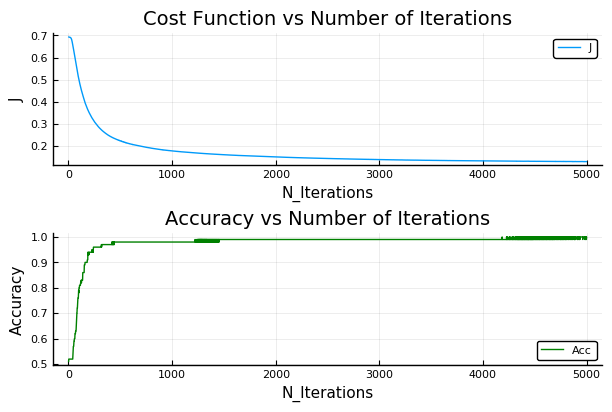

4910
Cost ->0.12922090835245695
Accuracy -> 1.0
Iteration ->4911
Cost ->0.1292409785869407
Accuracy -> 0.99
Iteration ->4912
Cost ->0.12911820165753837
Accuracy -> 1.0
Iteration ->4913
Cost ->0.129123762165344
Accuracy -> 1.0
Iteration ->4914
Cost ->0.129067710309297
Accuracy -> 1.0
Iteration ->4915
Cost ->0.12920987181804616
Accuracy -> 1.0
Iteration ->4916
Cost ->0.12925247825901853
Accuracy -> 0.99
Iteration ->4917
Cost ->0.12954003635873013
Accuracy -> 1.0
Iteration ->4918
Cost ->0.1291905706642894
Accuracy -> 0.99
Iteration ->4919
Cost ->0.1291113434433361
Accuracy -> 1.0
Iteration ->4920
Cost ->0.1293945864082957
Accuracy -> 1.0
Iteration ->4921
Cost ->0.12898697115698995
Accuracy -> 1.0
Iteration ->4922
Cost ->0.12928227391611183
Accuracy -> 1.0
Iteration ->4923
Cost ->0.129131680416976
Accuracy -> 1.0
Iteration ->4924
Cost ->0.12914473453096076
Accuracy -> 1.0
Iteration ->4925
Cost ->0.1291517468523272
Accuracy -> 1.0
Iteration ->4926
Cost ->0.129251282561584
Accuracy -> 1.0
It

(Dict{Any,Any}("b_1" => [-0.632102340488601; -2.6876713490502055; … ; -0.19473731281854822; -2.762980530855747],"W_2" => [1.1418714898219589 1.2484235262491625 … 0.09048844267663354 1.2481265646777195],"b_2" => [-11.783824499047146],"g_2" => "sigmoid","W_1" => [1.1457851492396351 -0.06329223871304437; 0.18096210781160862 -1.2041103899000638; … ; 0.013120006659433855 -0.08727682091369066; 0.30493505620530587 1.1518297118580358],"g_1" => "relu"), Any[0.6931602663848241, 0.6930492333862748, 0.6929461564232736, 0.6928493423698049, 0.6927562899890911, 0.6926655384144295, 0.6925751522840922, 0.692482550783098, 0.6923857977919335, 0.6922833763206089  …  0.1290358005560498, 0.1290119496469937, 0.12884898306261366, 0.1288668689468489, 0.12911065244527545, 0.1289874160046585, 0.12927744976765312, 0.12906693365309554, 0.1289664296815468, 0.12884995601796842])

In [95]:
# using Pkg
# Pkg.add("Plots")
# Pkg.add("PyPlot")
layers_dimensions = (2,6,1)
activation_functions = ["relu", "sigmoid"]
X = rand(-10:10, 2, 100)
Y = (abs.(X[1,:])+abs.(X[2,:])).>10
Y=Y'
learning_rate = 0.2
n_iter = 5000
lambda = 1
params, costs = train_nn(layers_dimensions, activation_functions, X , Y , learning_rate , n_iter, lambda)
